# Classification of the CIFAR-10 dataset

The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) provides 60000 32x32-pixel images, classified into 10 categories.  The figure below provides a random sample of some images in each category.

![images.png](images.png)

During this session, you will learn how to build a Convolutional Neural Network (CNN), which (when trained) will be able to automatically classify new images into one of these categories.  We will make use of the [Keras library](https://www.tensorflow.org/guide/keras) which provides a high-level interface to TensorFlow. Begin by importing the necessary modules.

In [ ]:
import os
import time
import datetime
from tqdm import tqdm_notebook

import numpy as np
import pandas
import matplotlib.pyplot as plt
from sklearn import metrics

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import datetime

from keras.layers import Dense, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, BatchNormalization
from keras.optimizers import SGD
from keras.datasets import cifar10
from keras.utils.np_utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import EarlyStopping

from tensorboard.plugins.hparams import api as hp

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import itertools as it
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

# Table of content

[1. A first look at the data set](#dataset)<br>

[2. A first naive model](#first_model)<br>

[3. Convolutional Neural Networks](#cnn)<br>
- [3.1 Create your first CNN](#first_cnn)<br>
- [3.2 Influence of parameters on the performance](#cnn_parameters)<br>
- [3.3 Studying predictions](#results)<br>

[4. Pretrained Networks](#pretrained_cnn)<br>


<a id='dataset'></a>
# 1 - A first look at the data set

**1) Download the dataset. See [`keras.datasets`](https://keras.io/datasets/) for how to download the data.  Note that the dataset is already divided into a training set of 50000 images, and a test set of 10000.**

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


**2) Check the shape of images and targets.**

In [ ]:
print(f"""Shape of the train dataset: {x_train.shape[0]} images of {x_train.shape[1]} * {x_train.shape[2]} pixels, with {x_train.shape[3]} color channels """)
print(f"""Shape of the train target: {y_train.shape[0]} labels """)
print(f"""Shape of the test dataset: {x_test.shape[0]} images of {x_test.shape[1]} * {x_test.shape[2]} pixels, with {x_test.shape[3]} color channels """)
print(f"""Shape of the test target: {y_test.shape[0]} labels """)

Shape of the train dataset: 50000 images of 32 * 32 pixels, with 3 color channels 
Shape of the train target: 50000 labels 
Shape of the test dataset: 10000 images of 32 * 32 pixels, with 3 color channels 
Shape of the test target: 10000 labels 


**3) Create a list of labels corresponding to the 10 categories.  This will be used to convert the 0-9 digits in the target arrays to string labels. The categories are labeled as follows**
  0. airplane
  1. automobile
  2. bird
  3. cat
  4. deer
  5. dog
  6. frog
  7. horse
  8. ship
  9. truck


In [ ]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

**4) Normalize images from [0,255] to be [0,1] (normalizing usually improves model training).**

In [ ]:
x_train_norm = x_train / 255
x_test_norm = x_test / 255

**5) Convert the target arrays to one-hot encodings.  Hint: checkout the [`keras.utils.to_categorical()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical)**

In [ ]:
y_train_encoded = tf.keras.utils.to_categorical(
    y_train, num_classes=None, dtype='float32'
)

y_test_encoded = tf.keras.utils.to_categorical(
    y_test, num_classes=None, dtype='float32'
)

**6) Visualize some images in each category using the `imshow()` function in `matplotlib.pyplot`.  Can you recreate the figure at the top?  Hint: the top figure was created using the first 8 images belonging to each category in the training data.**

In [ ]:
print(x_train.dtype, y_train.dtype)

uint8 uint8


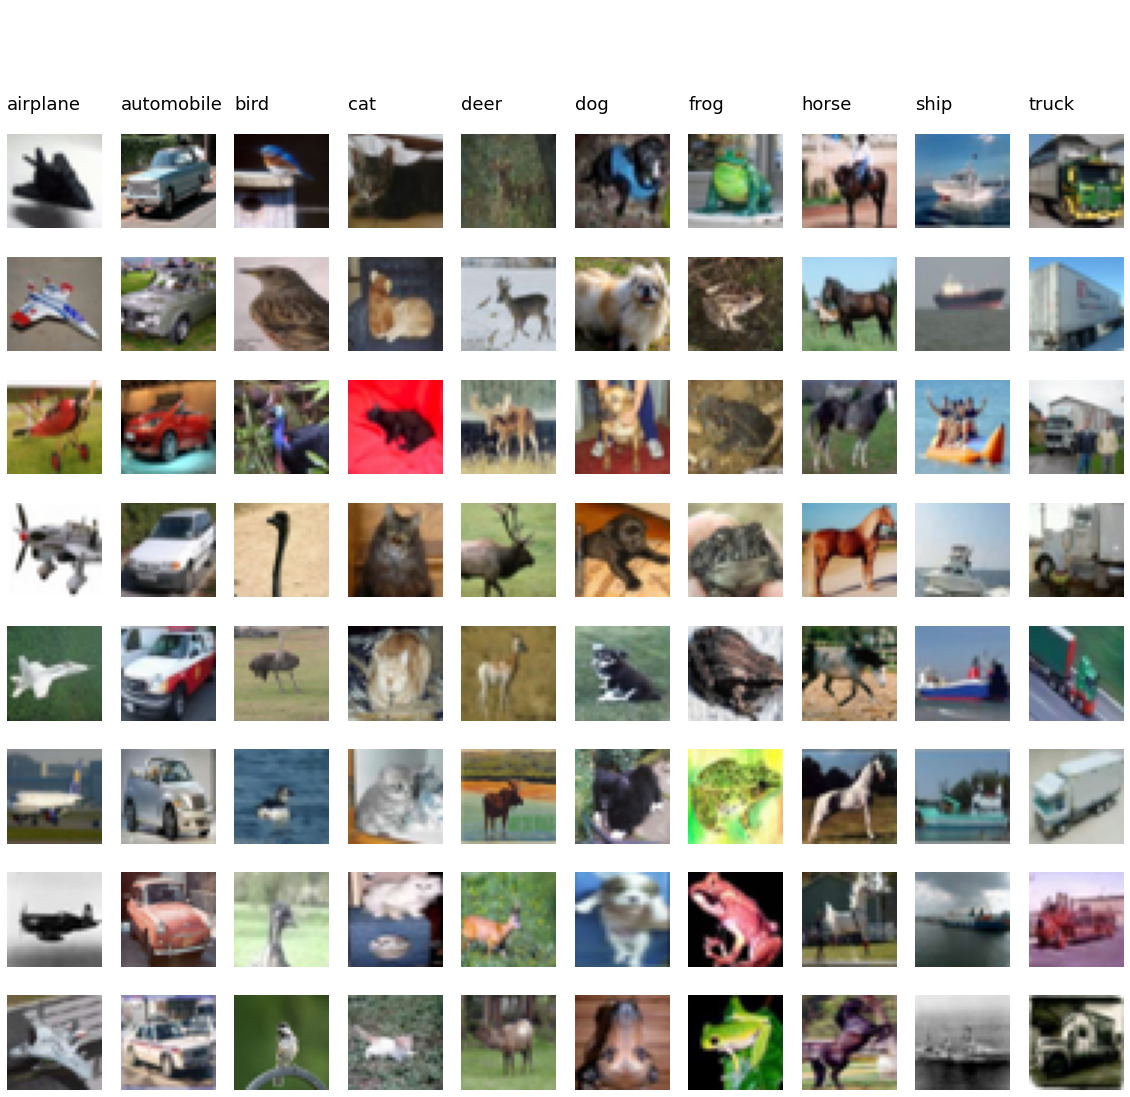

In [ ]:
def plot_first_images(x_train, y_train, labels):
    """A function to plot the 8 first images of the categories contained in a
    list.

    Args:
        x_train ([ndarray]): [Array containing the training images.]
        y_train ([ndarray]): [Array containing the labels of the images.]
        labels ([list]): [List containing all the unique labels.]
    """
    count = np.zeros(10)
    eights = np.ones(10) * 8
    i = 0
    fig, ax = plt.subplots(9, 10, figsize=(20, 20))
    
    for i, label in enumerate(labels):
        subplot = ax[0, i]
        subplot.axis('off')
        txt = subplot.text(0, 0, label, fontsize=18)
        txt.set_clip_on(False)

    while 1:
        if count[y_train[i][0]] < 8:
            count[y_train[i][0]] += 1
            subplot = ax[int(count[y_train[i][0]]), y_train[i][0]]
            subplot.imshow(x_train[i])
            subplot.axis('off')
        i += 1
        if np.array_equal(count, eights):
            break

plot_first_images(x_train, y_train, labels)

The following code summarizes the previous operations. 

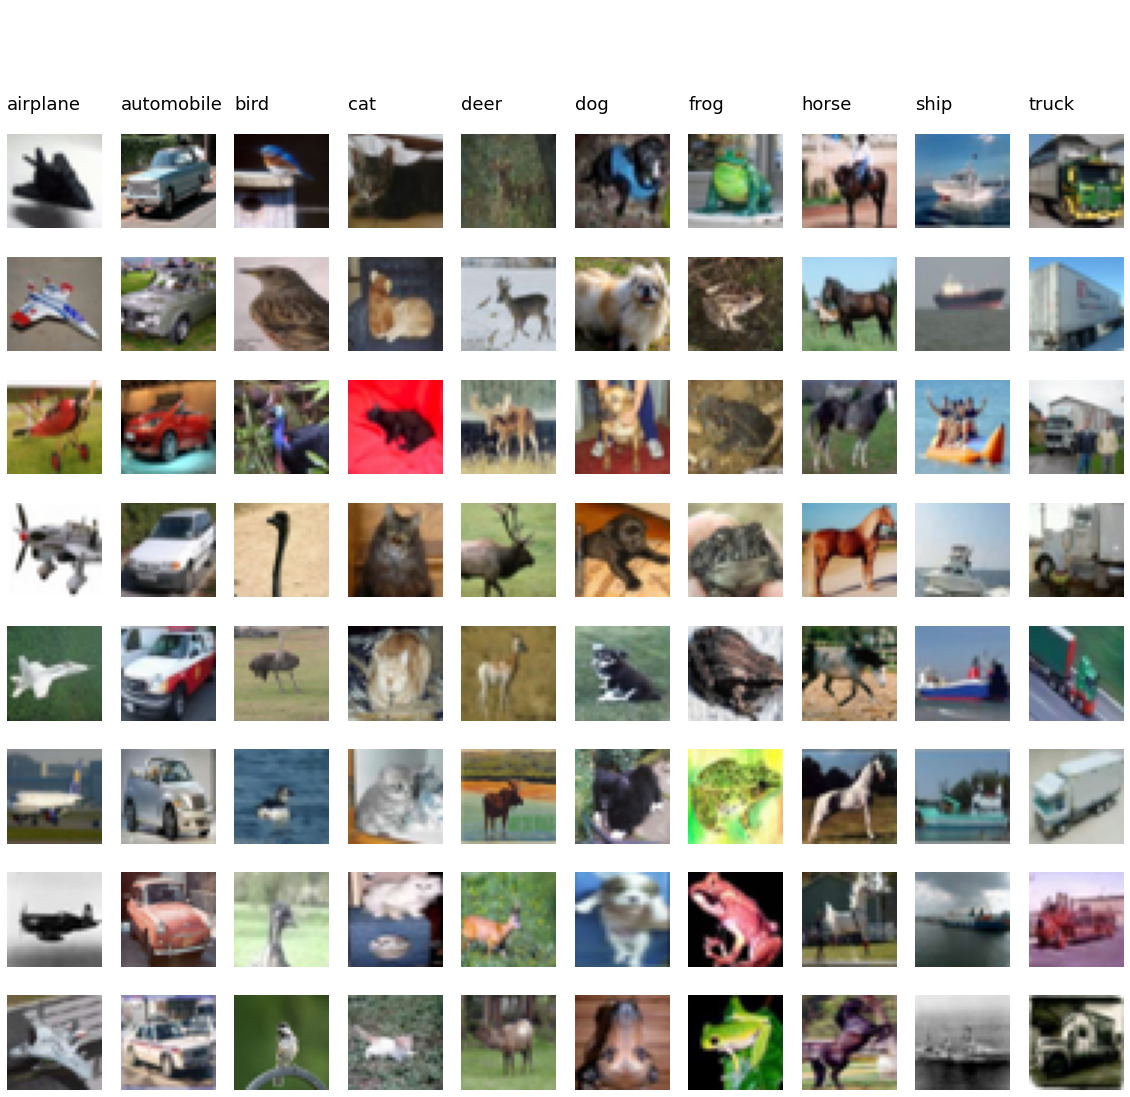

In [ ]:
def load_and_plot(database="cifar10"):
    """A function to load the data and plot the first images.

    Args:
        database (str, optional): [Name of the Keras dataset to load.]. Defaults to "cifar10".

    Returns:
        [tuple]: [Returns the normalized xtrain and xtest, and the encoded ytrain and ytest. ]
    """
    # LOAD
    if (database == "cifar10"):
        database = tf.keras.datasets.cifar10
    (x_train, y_train), (x_test, y_test) = database.load_data()
    
    # DEFINE LABELS
    labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    
    # NORMALIZE
    x_train_norm = x_train / 255
    x_test_norm = x_test / 255
    y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=None, dtype='float32')
    y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=None, dtype='float32')
    
    # PLOT
    plot_first_images(x_train, y_train, labels)

    return x_train_norm, x_test_norm, y_train_encoded, y_test_encoded
    
x_train_norm, x_test_norm, y_train_encoded, y_test_encoded = load_and_plot()


<a id='first_model'></a>

# 2 - First naive model

In order to better understand the importance of CNNs, it is instructive to first see how well a naive dense network performs on the dataset.

**7) Create a sequential model with 4 `Dense` hidden layers of 2048, 1024, 512, and 256 nodes each, with ReLU activation, and a linear output layer of 10 nodes. Compile the model with a `categorical_crossentropy` loss, using the SGD optimizer, including the `accuracy` metric. 
Note that you will need to use the `Flatten` layer first in order to convert the 3D (x, y, rgb) image data into 1D.**

In [ ]:
input_size = 32 * 32
hidden_sizes = [2048, 1024, 512, 256]
output_size = 10

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(32, 32, 3)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(hidden_sizes[0], activation='relu'))
model.add(tf.keras.layers.Dense(hidden_sizes[1], activation='relu'))
model.add(tf.keras.layers.Dense(hidden_sizes[2], activation='relu'))
model.add(tf.keras.layers.Dense(hidden_sizes[3], activation='relu'))
model.add(tf.keras.layers.Dense(output_size, activation='linear'))

model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

**8) Compute by hand the total number of trainable parameters (weights and biases) in the model.**

The number of parameters is :

   (3072 + 1) * 2048

\+ (2048 + 1) * 1024

\+ (1024 + 1) * 512

\+ (512 + 1) * 256

\+ (256 + 1) * 10

= 9 050 378

**9) Use the `summary()` function on model to get a text summary of the model.  Did you compute the number of parameters correctly?**

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              6293504   
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                2570      
Total params: 9,050,378
Trainable params: 9,050,378
Non-trainable params: 0
______________________________________________

**10) Train the model for 10 epochs, with a batch size of 32 (you may also use early stopping). What is the model performance?**

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

model.fit(x_train_norm, y_train_encoded, epochs=10, batch_size = 32,
          validation_data=(x_test_norm, y_test_encoded),
          callbacks=[early_stop])

Epoch 1/10
1563/1563 [==============================] - 8s 4ms/step - loss: 11.1339 - accuracy: 0.0985 - val_loss: 11.2682 - val_accuracy: 0.1000
Epoch 2/10
1563/1563 [==============================] - 5s 3ms/step - loss: 11.2232 - accuracy: 0.0983 - val_loss: 11.2682 - val_accuracy: 0.1000
Epoch 3/10
1563/1563 [==============================] - 5s 3ms/step - loss: 11.2553 - accuracy: 0.0999 - val_loss: 11.2682 - val_accuracy: 0.1000
Epoch 4/10
1563/1563 [==============================] - 5s 3ms/step - loss: 11.2017 - accuracy: 0.0973 - val_loss: 11.2682 - val_accuracy: 0.1000


The model has an accuracy of 0.10 which is identical to a naive random estimator. Using a softmax output function would have produced better results than a linear output function. 

**11) Plot several images with their predictions. Any comment?**

In [ ]:
def plot_predictions(x_test, y_test, y_predict, labels, sample_size=5):
    """ Plots a sample of predicted images. The function shows 3 elements : the
    predicted image, an histogram of the prediction weights and a comparison of
    the label with the max weight with the real label to see if the prediction
    is correct.

    Args:
        x_test ([ndarray]): [Array containing the test images.]
        y_test ([ndarray]): [Array containing the labels of the test images.]
        y_predict ([ndarray]): [Array containing all of the predicted weights.]
        labels ([list]): [List containing all of the unique labels.]
        sample_size (int, optional): [Number of examples to show]. Defaults to 5.
    """
    fig, ax = plt.subplots(nrows=sample_size, ncols=3, figsize=(15, 20))
    
    for i in range(sample_size):
    
        image_subplot = ax[i, 0]
        image_subplot.axis('off')
        image_subplot.imshow(x_test[i])

        pred_plot = ax[i, 1]
        pred_plot.barh(labels, y_predict[i])
        conclusion_plot = ax[i, 2]
        conclusion_plot.axis('off')
        if labels[np.argmax(y_predict[i])] == labels[y_test[i][0]]:
            smiley = ":-)"
        else:
            smiley = ":-("
        format_str = f"predicted: {labels[np.argmax(y_predict[i])]} vs truth: {labels[y_test[i][0]]}\n{smiley}"
        txt = conclusion_plot.text(0, 0, format_str, fontsize=18)
        txt.set_clip_on(False)

313/313 [==============================] - 0s 1ms/step


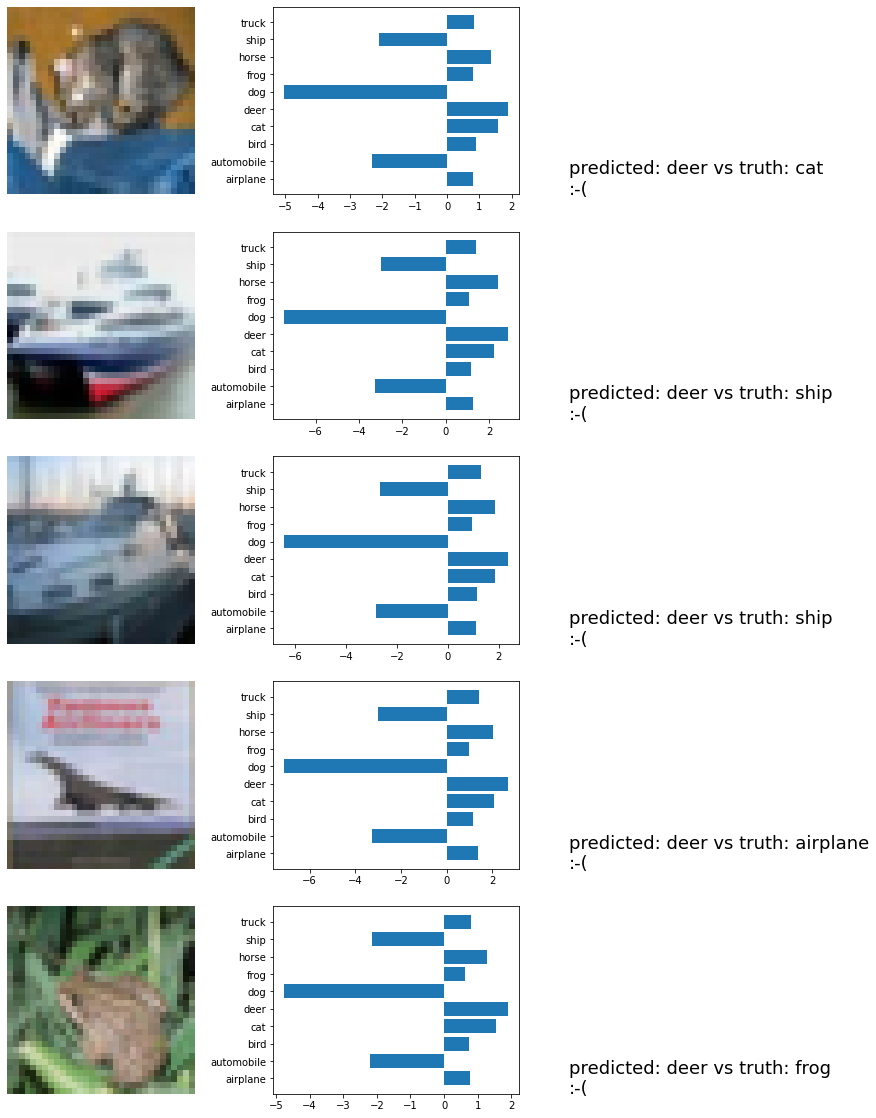

In [ ]:
predictions = model.predict(
    x_test_norm, batch_size=None, verbose=1, steps=None, callbacks=None, max_queue_size=10,
    workers=1, use_multiprocessing=False)

plot_predictions(x_test, y_test, predictions, labels, sample_size=5)

On a subsample of 5 images, the classifier failed to make any correct prediction (by pure luck).

<a id='cnn'></a>

# 3 - Convolutional Neural Network
 

Convolutional neural networks allow us to do drastically better on this dataset (and many image classification problems in general).  In this task, you will build your first convolutional network and see how it performs during training.

<a id='first_cnn'></a>
## 3.1 - Create your first CNN

In [ ]:
def create_model(hparams, print_summary=False):
    """ Creates a CNN model, given a dictionary containing the paramerters of 
    the model. A model summary can also be printed.

    Args:
        hparams ([dict]): [A dictionary of model parameters. The available
        parameters are :
        - 'batch_normalization' (boolean): Adds two Batch normalization layers
        before the dropout layers. 
        - optimizer (str) : Type of optimizer to use.
        - dropout (float) : The dropout rate, between 0 and 1.
        ]
        print_summary (bool, optional): [Whether to print a model summary at the
        end]. Defaults to False.

    Returns:
        [class]: [Returns a Keras Sequential object.]
    """
    model_conv = tf.keras.models.Sequential()
    model_conv.add(tf.keras.Input(shape=(32, 32, 3)))
    model_conv.add(tf.keras.layers.Conv2D(filters=32, 
                        kernel_size=(3, 3),
                        padding='same',
                        activation='relu'))

    model_conv.add(tf.keras.layers.Conv2D(filters=32, 
                        kernel_size=(3, 3),
                        activation='relu'))
    
    if hparams['batch_normalization'] is True:
        model_conv.add(tf.keras.layers.BatchNormalization())
    model_conv.add(tf.keras.layers.Dropout(rate=hparams["dropout"]))

    model_conv.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

    model_conv.add(tf.keras.layers.Conv2D(filters=64, 
                        kernel_size=(3, 3),
                        activation='relu'))

    model_conv.add(tf.keras.layers.Conv2D(filters=64, 
                        kernel_size=(3, 3),
                        activation='relu'))
    
    if hparams['batch_normalization'] is True:
        model_conv.add(tf.keras.layers.BatchNormalization())
    model_conv.add(tf.keras.layers.Dropout(rate=hparams["dropout"]))

    model_conv.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    model_conv.add(tf.keras.layers.Flatten())
    model_conv.add(tf.keras.layers.Dense(512, activation='relu'))

    if hparams['batch_normalization'] is True:
        model_conv.add(tf.keras.layers.BatchNormalization())
    model_conv.add(tf.keras.layers.Dropout(rate=hparams["dropout"]))

    model_conv.add(tf.keras.layers.Dense(10, activation='softmax'))

    model_conv.compile(loss='categorical_crossentropy',
                 optimizer=hparams["optimizer"],
                 metrics=['accuracy'])
    
    if print_summary is True:
        model_conv.summary()

    return model_conv

In [ ]:
class UniversalHPOptimizer():
    """ A class to optimize a given model and a given dictionary of parameters
    to test. It uses the Tensorboard API in order to log the results.
    
    """

    def __init__(self, dict_params, create_model, print_summary=False):
        """

        Args:
            dict_params ([dict]): [Dictionary which values are lists of possible
             values for each parameter to test in the GridSearch.]
            create_model ([funct]): [Function to create the model.]
            print_summary (bool, optional): [Whether to print a summary of the model.
            ]. Defaults to False.
        """
        self.user_input = dict_params
        self.create_model = create_model
        self.print_summary=print_summary
        self.best_model = None
        self.best_accuracy = None
        self.METRIC_ACCURACY = 'accuracy'

        if "batch_normalization" not in dict_params:
            self.HP_BATCH_NORMALIZATION = hp.HParam('batch_normalization', hp.Discrete([False], dtype=bool))
        else:
            self.HP_BATCH_NORMALIZATION = dict_params['batch_normalization']

        if "epochs" not in dict_params:
            self.HP_EPOCHS = hp.HParam('epochs', hp.Discrete([10]))
        else:
            self.HP_EPOCHS = dict_params["epochs"]

        if "batch_size" not in dict_params:
            self.HP_BATCH_SIZE = hp.HParam('batch_size', hp.Discrete([32]))
        else:
            self.HP_BATCH_SIZE = dict_params["batch_size"]

        if "dropout" not in dict_params:
            self.HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0]))
        else:
            self.HP_DROPOUT = dict_params["dropout"]

        if "num_units" not in dict_params:
            self.HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([32]))
        else:
            self.HP_NUM_UNITS = dict_params["num_units"]

        if "optimizer" not in dict_params:
            self.HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['SGD']))
        else:
            self.HP_OPTIMIZER = dict_params["optimizer"]

    def run_all(self, x_train, y_train, x_test, y_test):
        """[summary]

        Args:
          x_train ([ndarray]): [Array containing the training images.]
          y_train ([ndarray]): [Array containing the labels of the training 
          images.]
          x_test ([ndarray]): [Array containing the training images.]
          y_test ([ndarray]): [Array containing the labels of the training 
          images.]
        """
        !rm -rf ./logs/
        session_num = 0
        with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
            hp.hparams_config(
                hparams=[self.HP_BATCH_SIZE, self.HP_DROPOUT, self.HP_OPTIMIZER, self.HP_NUM_UNITS,
                         self.HP_BATCH_NORMALIZATION, self.HP_EPOCHS],
                         metrics=[hp.Metric(self.METRIC_ACCURACY, display_name='Accuracy')])

        all_params = {}
        all_params['dropout'] = self.HP_DROPOUT.domain.values
        all_params['epochs'] = self.HP_EPOCHS.domain.values
        all_params['batch_size'] = self.HP_BATCH_SIZE.domain.values
        all_params['optimizer'] = self.HP_OPTIMIZER.domain.values
        all_params['num_units'] = self.HP_NUM_UNITS.domain.values
        all_params['batch_normalization'] = self.HP_BATCH_NORMALIZATION.domain.values

        keys, values = zip(*all_params.items())
        combinations = [dict(zip(keys, v)) for v in it.product(*values)]

        for hparams in combinations:
            run_name = "run-%d" % session_num
            print('\n--- Starting trial: %s' % run_name)
            print({k: v for k, v in hparams.items()})
            self.run(hparams, x_train, y_train, x_test, y_test, 'logs/hparam_tuning/' + run_name)
            session_num += 1


    def train_test_model(self, hparams, x_train, y_train, x_test, y_test):
        """[summary]

        Args:
            hparams ([dict]): [A dictionary of model parameters. The available
            parameters are :
            - batch_normalization (boolean): Adds two Batch normalization layers
            before the dropout layers. 
            - optimizer (str) : Type of optimizer to use.
            - dropout (float) : The dropout rate, between 0 and 1.
            - batch_size (int): size of the batch.
            - epoch (int): number of epochs.
            ]
            x_train ([ndarray]): [Array containing the training images.]
            y_train ([ndarray]): [Array containing the labels of the training 
            images.]
            x_test ([ndarray]): [Array containing the training images.]
            y_test ([ndarray]): [Array containing the labels of the training 
            images.]

        Returns:
            [float]: [Returns the scalar test loss of the test.]
        """
        model = self.create_model(hparams, self.print_summary)
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

        params_callback = {}
        for k, v in hparams.items():
            if k in self.user_input:
                params_callback[k] = v

        tensorboard_callback = [tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),
                                hp.KerasCallback(log_dir, params_callback)]

        model.fit(x_train_norm, y_train_encoded, batch_size=hparams["batch_size"], epochs=hparams["epochs"],
                  callbacks=[tensorboard_callback], validation_data=(x_test_norm, y_test_encoded)) 
        _, accuracy = model.evaluate(x_test_norm, y_test_encoded)

        if self.best_accuracy is None or accuracy > self.best_accuracy:
            self.best_accuracy = accuracy
            self.best_model = model

        return accuracy

    def run(self, hparams, x_train, y_train, x_test, y_test, run_dir="."):
        """[summary]

        Args:
            hparams ([dict]): [A dictionary of model parameters. The available
            parameters are :
            - batch_normalization (boolean): Adds two Batch normalization layers
            before the dropout layers. 
            - optimizer (str) : Type of optimizer to use.
            - dropout (float) : The dropout rate, between 0 and 1.
            - batch_size (int): size of the batch.
            - epoch (int): number of epochs.
            ]
            x_train ([ndarray]): [Array containing the training images.]
            y_train ([ndarray]): [Array containing the labels of the training 
            images.]
            x_test ([ndarray]): [Array containing the training images.]
            y_test ([ndarray]): [Array containing the labels of the training 
            images.]
            run_dir (str, optional): [Path to the directory from which to run 
            the model.]. Defaults to ".".
        """

        with tf.summary.create_file_writer(run_dir).as_default():
            hp.hparams(hparams)  # record the values used in this trial
            accuracy = self.train_test_model(hparams, x_train, y_train, x_test, y_test)
            tf.summary.scalar(self.METRIC_ACCURACY, accuracy, step=1)

 
    def predict(self, x_test):
        """ Predicts the results for x_test with the model.

        Args:
            x_test ([ndarray]): [Array containing the training images.]

        Returns:
            [tuple]: [Returns an array of weights for predictions and an 
            array of predicted labels.]
        """
        predicted_probas = self.best_model.predict(x_test, verbose=1, max_queue_size=10)
        predicted_classes = np.argmax(predicted_probas, axis=-1)
        return predicted_probas, predicted_classes


    def get_confusion_matrix(self, y_true, x_test=None, y_pred=None, labels=None):
        """ Builds a confusion matrix for the model.

        Args:
            y_true ([ndarray]): [Array containing the true labels.]
            x_test ([ndarray]): [Array containing the training images.]. Defaults to None.
            y_pred ([ndarray]): [Array containing the weigths for the prediction.]. Defaults to None.
            labels ([list], optional): [List containing all of the unique labels.]. Defaults to None. 

        Returns:
            [DataFrame]: [Returns a pandas DataFrame containing the confusion matrix, 
            with the rows being the true labels and the columns the predicted labels.]
        """
        real_labels = ["real " + label for label in labels]
        pred_labels = ["pred " + label for label in labels]
        if y_pred is None:
            _, y_pred = self.predict(x_test)
        conf_matrix = tf.math.confusion_matrix(y_true, y_pred).numpy()
        df_conf_matrix = pd.DataFrame(conf_matrix, index=real_labels, columns=pred_labels)
        return df_conf_matrix


In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


**12) Create a new model with the following layers (use the same optimizer and loss as above)**
  - 3x3 2D convolution with zero padding (same), 32 filters
  - ReLU activation
  - 3,3 2D convolution, no padding, 32 filters
  - ReLU activation
  - Max pooling with size (2,2)
  - 3x3 2D convolution, no padding, 64 filters
  - ReLU activation
  - 3x3 2D convolution, no padding, 64 filters
  - ReLU activation
  - Max pooling with size (2,2)
  - Flatten
  - Dense layer with 512 nodes, ReLU activation
  - Softmax output layer with 10 nodes

In [ ]:
params = {
    "epochs": hp.HParam('epochs', hp.Discrete([10])),
    "batch_size": hp.HParam('batch_size', hp.Discrete([32]))
}

universal_optimizer = UniversalHPOptimizer(params, create_model, print_summary=True)

This cell instantiates an object from the class UniversalHPOptimizer that we coded to mimic the behaviour of GridSearchCV and be compatible with the web-app Tensorboard. This class will be used further for hyper-parameter tuning. It takes as input a dictionary of hyperparameters and a method to create the models

**13) Compute by hand the number of trainable parameters in this network.  Are there more or less than the more simple dense network?  Why?  Confirm with `summary()`.**

Let's first compute the size of the input layer. There are 32 pixels, but the filter is of size 3*3, so $\text{initial input size} = 32 - (3*3 - 1)$. However, the image is zero-padded with a padding of 2, so we add 2 rows and 2 columns of 0 to the image. Therefore, $\text{input size} = 32 - (3*3 - 1) + 2*2 = 28$. We therefore have the following results :
- Input layer : $32*28 = 896$
- Conv2D layer : $(3*3*32+1)*32 = 9248$
- Conv2D layer :$(3*3*32+1)*64 = 18496$
- Conv2D layer :$(3*3*64+1)*64 = 36928$
- Dense layer :$(1600+1)*512 = 819712$
- Output layer :$(512+1)*10 = 5130$
- Total : $890410$

**14) Train the network for 10 epochs, with batch size of 32. How does the validation accuracy change with each epoch?**

In [ ]:
universal_optimizer.run_all(x_train_norm, y_train_encoded, x_test_norm, y_test_encoded)


--- Starting trial: run-0
{'dropout': 0, 'epochs': 10, 'batch_size': 32, 'optimizer': 'SGD', 'num_units': 32, 'batch_normalization': False}
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 11, 11, 6

In [ ]:
model_conv = universal_optimizer.best_model
predictions = model_conv.predict(
    x_test_norm, batch_size=None, verbose=1, steps=None, callbacks=None, max_queue_size=10,
    workers=1, use_multiprocessing=False)

313/313 [==============================] - 1s 2ms/step


We can see on the graph below extracted from Tensorboard, that the validation accuracy increases in a concave way. The marginal progress the network makes between 2 epochs decreases until convergence.

In [ ]:
%tensorboard --logdir logs/fit

![validation_accuracy_vs_epoch](https://raw.githubusercontent.com/hehlinge42/cnn/master/assets/0_validation_accuracy_vs_epoch.png)

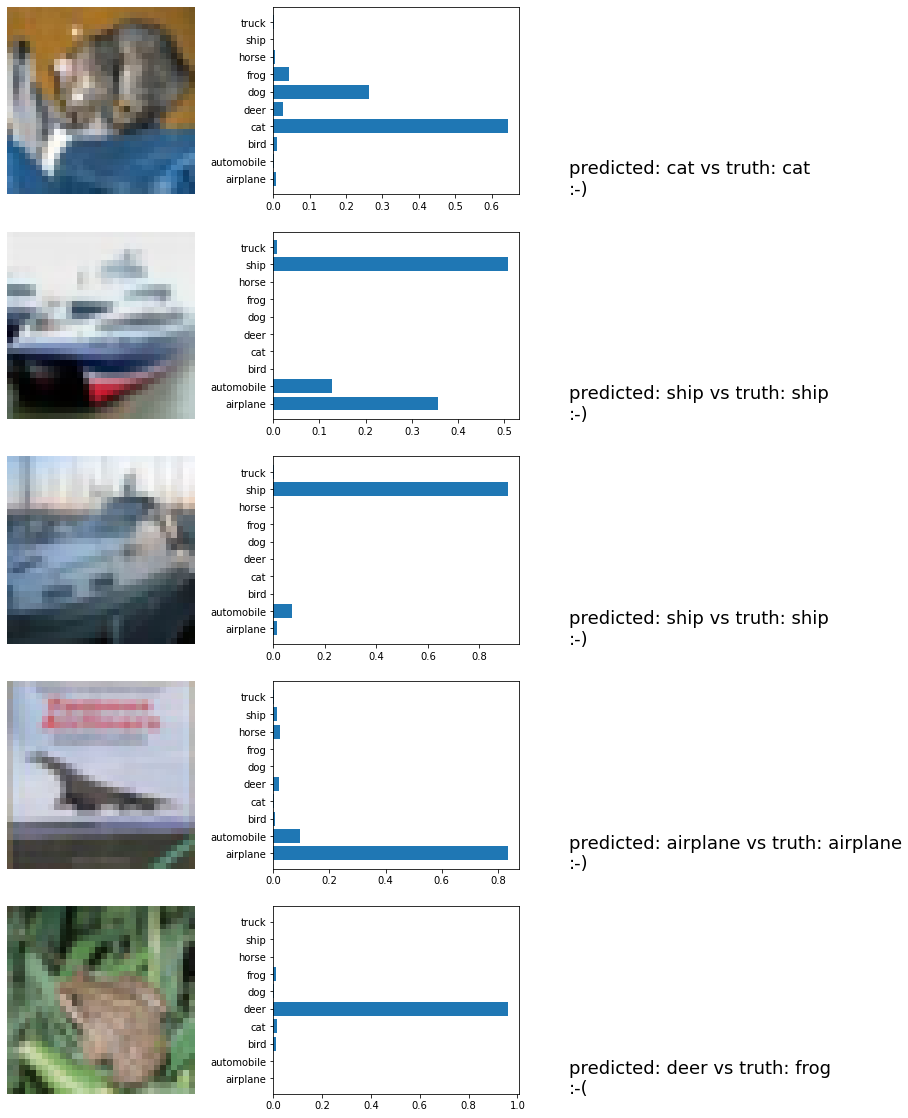

In [ ]:
plot_predictions(x_test, y_test, predictions, labels, sample_size=5)

<a id='cnn_parameters'></a>
## 3.2 - Influence of parameters on the performance

**15) How does the performance depend on batch size?**

In [ ]:
hp_param = {'batch_size': hp.HParam('batch_size', hp.Discrete([16, 32, 64]))}
universal_optimizer = UniversalHPOptimizer(hp_param, create_model)
universal_optimizer.run_all(x_train_norm, y_train_encoded, x_test_norm, y_test_encoded)


--- Starting trial: run-0
{'dropout': 0, 'epochs': 10, 'batch_size': 16, 'optimizer': 'SGD', 'num_units': 32, 'batch_normalization': False}
Epoch 1/10
3125/3125 [==============================] - 12s 4ms/step - loss: 2.0769 - accuracy: 0.2255 - val_loss: 1.5372 - val_accuracy: 0.4391
Epoch 2/10
3125/3125 [==============================] - 11s 3ms/step - loss: 1.4633 - accuracy: 0.4756 - val_loss: 1.3008 - val_accuracy: 0.5355
Epoch 3/10
3125/3125 [==============================] - 11s 4ms/step - loss: 1.2754 - accuracy: 0.5468 - val_loss: 1.1732 - val_accuracy: 0.5860
Epoch 4/10
3125/3125 [==============================] - 11s 4ms/step - loss: 1.1192 - accuracy: 0.6042 - val_loss: 1.1333 - val_accuracy: 0.6032
Epoch 5/10
3125/3125 [==============================] - 11s 3ms/step - loss: 1.0100 - accuracy: 0.6449 - val_loss: 1.0520 - val_accuracy: 0.6327
Epoch 6/10
3125/3125 [==============================] - 11s 4ms/step - loss: 0.9021 - accuracy: 0.6833 - val_loss: 1.0193 - val_accura

The accuracy is inversely proportional to the batch size: a small batch size gives a good accuracy, a big batch size gives a worse accuracy.

In [ ]:
%tensorboard --logdir logs/fit

![batch_size](https://raw.githubusercontent.com/hehlinge42/cnn/master/assets/1_batch_size.png)

**16) Note how the validation accuracy begins to decrease at some point, while the training accuracy continues to increase.  What is this phenomenon?  Try adding 3 dropout layers to the model, one before each max pooling layer and one before the last layer, using a dropout ratio of 0.25.  Does this improve the model? How does the performance vary with the dropout ratio?**

In [ ]:
hp_param = {'epochs': hp.HParam('epochs', hp.Discrete([20]))}
test = UniversalHPOptimizer(hp_param, create_model)
test.run_all(x_train_norm, y_train_encoded, x_test_norm, y_test_encoded)


--- Starting trial: run-0
{'dropout': 0, 'epochs': 20, 'batch_size': 32, 'optimizer': 'SGD', 'num_units': 32, 'batch_normalization': False}
Epoch 1/20
1563/1563 [==============================] - 8s 5ms/step - loss: 2.1701 - accuracy: 0.1958 - val_loss: 1.7944 - val_accuracy: 0.3521
Epoch 2/20
1563/1563 [==============================] - 7s 5ms/step - loss: 1.6645 - accuracy: 0.4067 - val_loss: 1.5147 - val_accuracy: 0.4540
Epoch 3/20
1563/1563 [==============================] - 7s 5ms/step - loss: 1.4274 - accuracy: 0.4913 - val_loss: 1.2989 - val_accuracy: 0.5397
Epoch 4/20
1563/1563 [==============================] - 7s 5ms/step - loss: 1.2814 - accuracy: 0.5457 - val_loss: 1.2327 - val_accuracy: 0.5594
Epoch 5/20
1563/1563 [==============================] - 7s 5ms/step - loss: 1.1703 - accuracy: 0.5851 - val_loss: 1.1490 - val_accuracy: 0.5921
Epoch 6/20
1563/1563 [==============================] - 7s 5ms/step - loss: 1.0888 - accuracy: 0.6177 - val_loss: 1.1865 - val_accuracy: 0.

By executing the model for 20 epochs, we make the algorithm overfit. At some point, the training accuracy continues to decrease while the validation accuracy oscillates

In [ ]:
%tensorboard --logdir logs/fit

![overfitting](https://raw.githubusercontent.com/hehlinge42/cnn/master/assets/2_overfitting.jpg)

In [ ]:
hp_param = {
    'epochs': hp.HParam('epochs', hp.Discrete([20])),
    'dropout': hp.HParam('dropout', hp.Discrete([0.0, 0.125, 0.25, 0.375], dtype=float))
}

universal_optimizer = UniversalHPOptimizer(hp_param, create_model)
universal_optimizer.run_all(x_train_norm, y_train_encoded, x_test_norm, y_test_encoded)


--- Starting trial: run-0
{'dropout': 0.0, 'epochs': 20, 'batch_size': 32, 'optimizer': 'SGD', 'num_units': 32, 'batch_normalization': False}
Epoch 1/20
1563/1563 [==============================] - 8s 5ms/step - loss: 2.1551 - accuracy: 0.1943 - val_loss: 1.7359 - val_accuracy: 0.3726
Epoch 2/20
1563/1563 [==============================] - 7s 4ms/step - loss: 1.6697 - accuracy: 0.4008 - val_loss: 1.4678 - val_accuracy: 0.4654
Epoch 3/20
1563/1563 [==============================] - 7s 5ms/step - loss: 1.4279 - accuracy: 0.4858 - val_loss: 1.3835 - val_accuracy: 0.4975
Epoch 4/20
1563/1563 [==============================] - 7s 5ms/step - loss: 1.3053 - accuracy: 0.5365 - val_loss: 1.3125 - val_accuracy: 0.5236
Epoch 5/20
1563/1563 [==============================] - 7s 5ms/step - loss: 1.1953 - accuracy: 0.5806 - val_loss: 1.2082 - val_accuracy: 0.5676
Epoch 6/20
1563/1563 [==============================] - 7s 5ms/step - loss: 1.1157 - accuracy: 0.6035 - val_loss: 1.2396 - val_accuracy: 

All four models (with dropout ratios 0, 0.125, 0.25, 0.375) converge around a val_accuracy of 70%. Nevertheless, we notice that the higher the dropout rate, the smaller the difference between the train accuracy and the validation accuracy, which indicates that models is less prone to overfitting.

In [ ]:
%tensorboard --logdir logs/fit

![dropout](https://raw.githubusercontent.com/hehlinge42/cnn/master/assets/3_dropout.png)

**17) Add batch normalization layers before each dropout layer. What is their impact on the model's performance?**

In [ ]:
hp_param = {
    'epochs': hp.HParam('epochs', hp.Discrete([20])),
    'dropout': hp.HParam('dropout', hp.Discrete([0.25], dtype=float)),
    'batch_normalization': hp.HParam('epochs', hp.Discrete([True, False]))
}

universal_optimizer = UniversalHPOptimizer(hp_param, create_model, print_summary=True)
universal_optimizer.run_all(x_train_norm, y_train_encoded, x_test_norm, y_test_encoded)


--- Starting trial: run-0
{'dropout': 0.25, 'epochs': 20, 'batch_size': 32, 'optimizer': 'SGD', 'num_units': 32, 'batch_normalization': False}
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
dropout_27 (Dropout)         (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 11, 1

In [ ]:
%tensorboard --logdir logs/fit

![batch_normalization](https://raw.githubusercontent.com/hehlinge42/cnn/master/assets/4_batch_normalization_impact.png)

Adding a batch normalization layer before each dropout layer makes validation accuracy slightly better.

<a id='results'></a>

## 3.3 - Studying predictions

Assuming all went well during the previous tasks, you can now predict the category of a new image!  Here are a few examples of my predictions:

![predictions.png](predictions.png)

**18) Use `predict` on your trained model to test its prediction on a few example images of the test set. Using `imshow` and `hbar` from `matplotlib.pyplot`, try to recreate the image above for a few example images.**

**Hint:** at this point, it is probably convenient to use the `save` and `load_model` functions from Keras.  You can save the model after training it, and then decide to load from saved file instead of building a new one (if available) on successive runs.

313/313 [==============================] - 1s 2ms/step


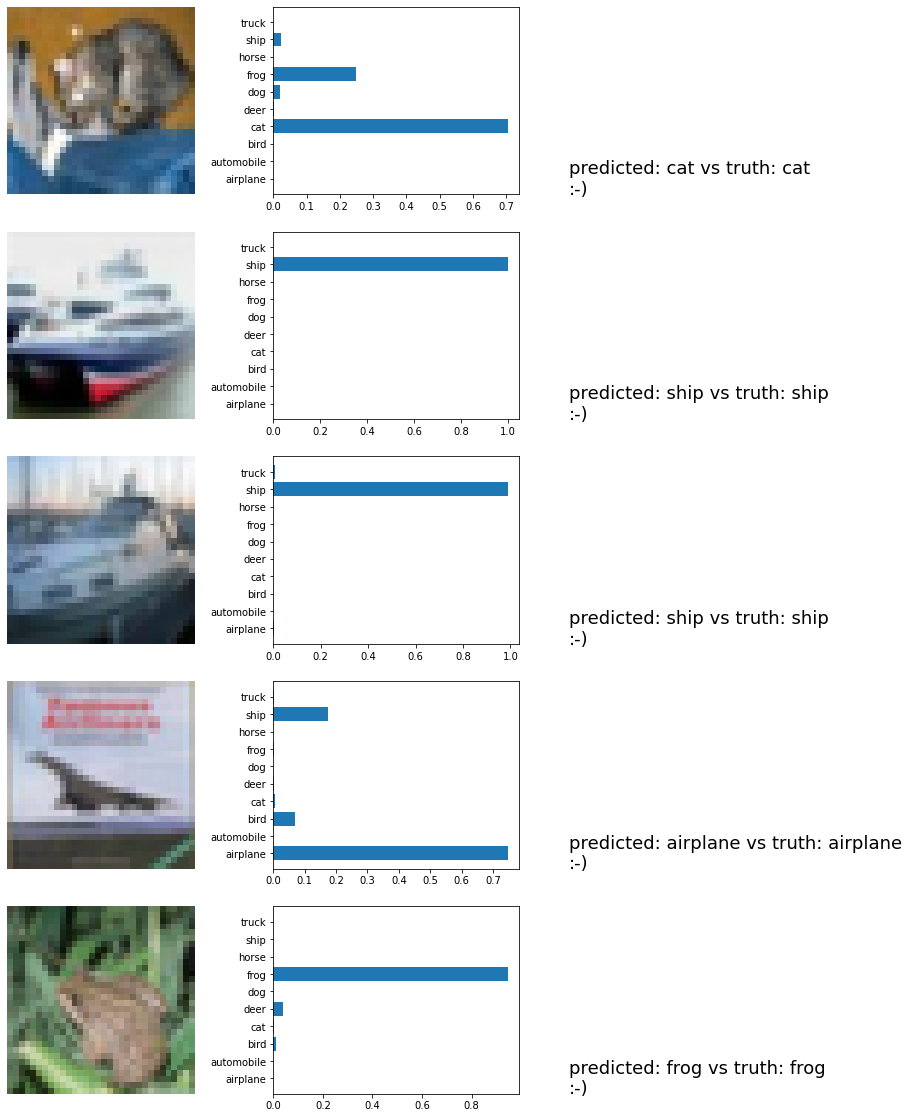

In [ ]:
predicted_probas, predicted_classes = universal_optimizer.predict(x_test_norm)
plot_predictions(x_test, y_test, predicted_probas, labels, sample_size=5)

A confusion matrix is often used in supervised learning to understand how well (or not) each category is being classified.  Each element (i,j) in the confusion matrix represents the predicted class j for each true class i.  Consider the following 10 predictions for a 2 category model predicting male or female.

| example     | true category  | predicted category  |
|-------------|----------------|---------------------|
| 1           | male           | male                |
| 2           | female         | male                |
| 3           | female         | female              |
| 4           | male           | male                |
| 5           | male           | female              |
| 6           | male           | male                |
| 7           | female         | female              |
| 8           | male           | female              |
| 9           | female         | female              |
| 10          | female         | female              |

Based on the above data, the model is accurate 70% of the time.  The confusion matrix is

|        | predicted male | predicted female |
|--------|------|--------|
| true male   | 3    | 2      |
| true female | 1    | 4      |

The confusion matrix gives us more information than a simple accuracy measurement. 

**19) Create the confusion matrix the CIFAR-10 dataset using the test data.  What does it tell you about the relationships between each class?**

In [ ]:
confusion_matrix = universal_optimizer.get_confusion_matrix(y_test, y_pred=predicted_classes, labels=labels)
confusion_matrix

,pred airplane,pred automobile,pred bird,pred cat,pred deer,pred dog,pred frog,pred horse,pred ship,pred truck
real airplane,646,3,48,34,81,10,27,14,114,23
real automobile,20,643,5,15,31,14,59,7,80,126
real bird,22,0,547,58,212,63,70,13,12,3
real cat,5,0,24,568,138,161,77,13,9,5
real deer,3,1,27,20,877,18,28,17,9,0
real dog,2,0,21,135,99,685,29,26,2,1
real frog,1,0,32,37,75,10,841,1,2,1
real horse,4,0,18,41,131,75,15,710,2,4
real ship,14,2,9,16,26,6,18,2,894,13
real truck,12,12,9,21,37,7,22,13,46,821


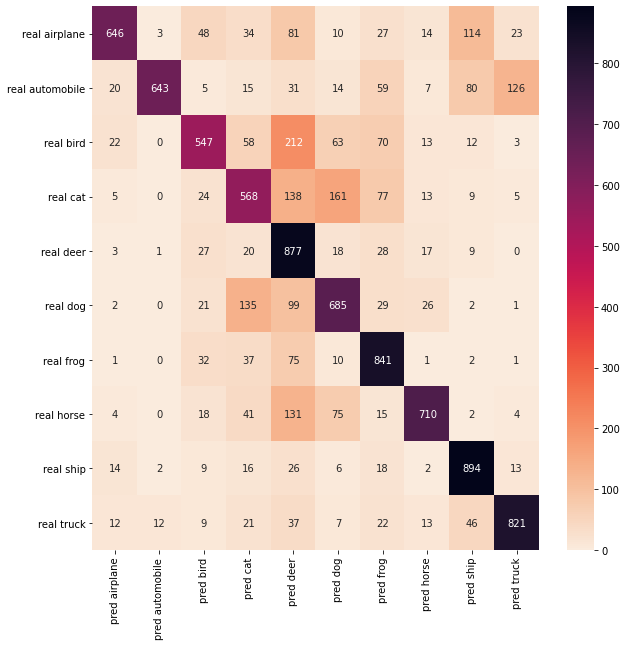

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, cmap='rocket_r', fmt='d')

Thanks to the confusion matrix, we can notice which classes the algorithm tends to mix up. For example, it mixes up cats and dogs as both classes have many similar features as they're both animals. Similarly, birds and planes are often mixed up.

<a id='pretrained_cnn'></a>
# 4 - Pretrained Networks

Note that several pre-trained networks are directly accessible via keras (see https://nbviewer.jupyter.org/github/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb)

**20) Build a classifier with a better accuracy on the test set than all CNN you have built before. One rule only: do not use CNN pretrained on CIFAR10.** 

In [ ]:
from keras.applications import InceptionResNetV2

model_origin = InceptionResNetV2(weights='imagenet',
                                 include_top=False,
                                 input_shape=(96, 96, 3))

model_origin.trainable = False

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.UpSampling2D(size=(3, 3)))
model.add(model_origin)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

In [ ]:
model.fit(x_train_norm, y_train_encoded, epochs=10, batch_size = 32,
          validation_data=(x_test_norm, y_test_encoded))

Epoch 1/10
1563/1563 [==============================] - 93s 53ms/step - loss: 1.1841 - accuracy: 0.6057 - val_loss: 0.8554 - val_accuracy: 0.7118
Epoch 2/10
1563/1563 [==============================] - 80s 51ms/step - loss: 0.7665 - accuracy: 0.7400 - val_loss: 0.8161 - val_accuracy: 0.7253
Epoch 3/10
1563/1563 [==============================] - 79s 51ms/step - loss: 0.6668 - accuracy: 0.7787 - val_loss: 0.7741 - val_accuracy: 0.7396
Epoch 4/10
1563/1563 [==============================] - 79s 50ms/step - loss: 0.6053 - accuracy: 0.7964 - val_loss: 0.7619 - val_accuracy: 0.7441
Epoch 5/10
1563/1563 [==============================] - 79s 50ms/step - loss: 0.5366 - accuracy: 0.8207 - val_loss: 0.7642 - val_accuracy: 0.7442
Epoch 6/10
1563/1563 [==============================] - 79s 50ms/step - loss: 0.4853 - accuracy: 0.8367 - val_loss: 0.7976 - val_accuracy: 0.7383
Epoch 7/10
1563/1563 [==============================] - 79s 50ms/step - loss: 0.4259 - accuracy: 0.8585 - val_loss: 0.7665 -

In [ ]:
_, accuracy = model.evaluate(x_test_norm, y_test_encoded)
print(accuracy)

313/313 [==============================] - 13s 42ms/step - loss: 0.8571 - accuracy: 0.7467
0.7466999888420105


Using the InceptionResNetV2 network inside a small custom model for only 2 epochs (for computational efficiency), we already obtain a very high accuracy rate on CIFAR-10